In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip -q install ultralytics opencv-python-headless pandas numpy pyyaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.9 MB/s eta 0:00:00


In [3]:
import os
import cv2
import math
import yaml
import numpy as np
import pandas as pd
from glob import glob
import shutil
import random
import matplotlib.pyplot as plt

In [4]:

TEST_DIR = "/content/drive/MyDrive/dtset/test_set/test_set"
TRAIN_DIR = "/content/drive/MyDrive/dtset/training_set/training_set"
YOLO_BASE = "/content/drive/MyDrive/hc_yolo_dataset"
TRAIN_CSV = "/content/drive/MyDrive/dtset/training_set_pixel_size_and_HC.csv"  # filename, pixel size(mm), head circumference (mm)
TEST_CSV  = "/content/drive/MyDrive/dtset/test_set_pixel_size.csv"

In [5]:
#yolo dataset
OUT_DATASET_DIR = "/content/drive/MyDrive/hc_yolo_seg_dataset"

BASE_DIR = "/content/drive/MyDrive/hc_yolo_dataset"

In [ ]:
folders = [
    "images/train",
    "images/val",
    "labels/train",
    "labels/val"
]

for f in folders:
    os.makedirs(os.path.join(BASE_DIR, f), exist_ok=True)

print("Done")

Done


In [ ]:
TRAIN_OUT = os.path.join(YOLO_BASE, "images/train")
VAL_OUT   = os.path.join(YOLO_BASE, "images/val")

for f in [TRAIN_OUT, VAL_OUT]:
    for file in os.listdir(f):
        os.remove(os.path.join(f, file))

all_images = glob(os.path.join(TRAIN_DIR, "*.png"))

images = [
    p for p in all_images
    if "_Annotation" not in os.path.basename(p)
]

print("Ultrasound images:", len(images))

random.seed(42)
random.shuffle(images)

split = int(0.8 * len(images))
train_imgs = images[:split]
val_imgs   = images[split:]

def copy_files(files, dst):
    for f in files:
        shutil.copy2(f, os.path.join(dst, os.path.basename(f)))

copy_files(train_imgs, TRAIN_OUT)
copy_files(val_imgs, VAL_OUT)

print("Done bro")

Ultrasound images: 1002
Done bro


In [ ]:
ORIGINAL_TRAIN_DIR = "/content/drive/MyDrive/dtset/training_set/training_set"
YOLO_BASE = "/content/drive/MyDrive/hc_yolo_dataset"

IMG_TRAIN = os.path.join(YOLO_BASE, "images/train")
IMG_VAL   = os.path.join(YOLO_BASE, "images/val")

LBL_TRAIN = os.path.join(YOLO_BASE, "labels/train")
LBL_VAL   = os.path.join(YOLO_BASE, "labels/val")

In [ ]:
CLASS_ID = 0
APPROX_EPS_RATIO = 0.003
MORPH_KERNEL = 3
MORPH_ITERS = 1

In [ ]:
def annotation_path_from_stem(stem: str) -> str:
    return os.path.join(ORIGINAL_TRAIN_DIR, f"{stem}_Annotation.png")


def load_binary_annotation(ann_path: str) -> np.ndarray:
    m = cv2.imread(ann_path, cv2.IMREAD_GRAYSCALE)
    if m is None:
        raise FileNotFoundError(f"Missing annotation file: {ann_path}")
    _, bin_m = cv2.threshold(m, 127, 255, cv2.THRESH_BINARY)
    return bin_m


def close_gaps(bin_m: np.ndarray) -> np.ndarray:
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (MORPH_KERNEL, MORPH_KERNEL))
    closed = cv2.morphologyEx(bin_m, cv2.MORPH_CLOSE, k, iterations=MORPH_ITERS)
    return closed


def fill_from_contour(bin_m: np.ndarray) -> np.ndarray:
    cnts, _ = cv2.findContours(bin_m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled = np.zeros_like(bin_m)
    if not cnts:
        return filled
    cv2.drawContours(filled, cnts, -1, 255, thickness=cv2.FILLED)
    return filled


def largest_contour(mask: np.ndarray):
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not cnts:
        return None
    return max(cnts, key=cv2.contourArea)


def simplify_contour(cnt, eps_ratio=APPROX_EPS_RATIO) -> np.ndarray:
    peri = cv2.arcLength(cnt, True)
    eps = eps_ratio * peri
    approx = cv2.approxPolyDP(cnt, eps, True)  # Nx1x2
    return approx.reshape(-1, 2).astype(np.float32)


def polygon_to_yolo_line(poly_xy: np.ndarray, w: int, h: int, class_id=0) -> str:
    poly = poly_xy.copy()
    poly[:, 0] /= float(w)
    poly[:, 1] /= float(h)
    poly = np.clip(poly, 0.0, 1.0)
    coords = " ".join([f"{x:.6f} {y:.6f}" for x, y in poly])
    return f"{class_id} {coords}"


def process_split(image_dir: str, label_dir: str, split_name: str):
    imgs = sorted(glob(os.path.join(image_dir, "*.png")))
    imgs = [p for p in imgs if "_Annotation" not in os.path.basename(p)]

    ok, missing_ann, bad_poly, empty_cnt = 0, 0, 0, 0

    print(f"\n=== Generating labels for {split_name} ===")
    print("Images found:", len(imgs))

    for img_path in imgs:
        stem = os.path.splitext(os.path.basename(img_path))[0]
        ann_path = annotation_path_from_stem(stem)

        if not os.path.exists(ann_path):
            missing_ann += 1
            continue

        img = cv2.imread(img_path)
        if img is None:
            continue
        h, w = img.shape[:2]

        bin_ann = load_binary_annotation(ann_path)

        bin_ann = close_gaps(bin_ann)

        filled = fill_from_contour(bin_ann)

        cnt = largest_contour(filled)
        if cnt is None or cv2.contourArea(cnt) < 10:
            empty_cnt += 1
            continue

        poly = simplify_contour(cnt, eps_ratio=APPROX_EPS_RATIO)
        if poly.shape[0] < 3:
            bad_poly += 1
            continue

        yolo_line = polygon_to_yolo_line(poly, w, h, CLASS_ID)
        out_path = os.path.join(label_dir, f"{stem}.txt")
        with open(out_path, "w") as f:
            f.write(yolo_line + "\n")

        ok += 1

    print("Done with labels", ok)
    print("Missing annotations:", missing_ann)
    print("Empty/invalid contour after fill:", empty_cnt)
    print("Too-small polygon after simplify:", bad_poly)


In [ ]:
process_split(IMG_TRAIN, LBL_TRAIN, "train")
process_split(IMG_VAL,   LBL_VAL,   "val")


=== Generating labels for train ===
Images found: 801
Done with labels 798
Missing annotations: 3
Empty/invalid contour after fill: 0
Too-small polygon after simplify: 0

=== Generating labels for val ===
Images found: 201
Done with labels 201
Missing annotations: 0
Empty/invalid contour after fill: 0
Too-small polygon after simplify: 0


In [ ]:
YOLO_BASE = "/content/drive/MyDrive/hc_yolo_dataset"

IMG_DIR = os.path.join(YOLO_BASE, "images/train")
LBL_DIR = os.path.join(YOLO_BASE, "labels/train")

In [ ]:
def load_yolo_polygon(label_path, w, h):
    with open(label_path, "r") as f:
        parts = f.readline().strip().split()
    coords = list(map(float, parts[1:]))  # skip class id
    poly = np.array(coords, dtype=np.float32).reshape(-1, 2)
    poly[:, 0] *= w
    poly[:, 1] *= h
    return poly

def overlay_polygon(img_bgr, poly_xy, thickness=2):
    out = img_bgr.copy()
    pts = poly_xy.reshape(-1, 1, 2).astype(np.int32)
    cv2.polylines(out, [pts], isClosed=True, color=(0, 255, 0), thickness=thickness)
    return out

In [ ]:
imgs = sorted(glob(os.path.join(IMG_DIR, "*.png")))
imgs = [p for p in imgs if "_Annotation" not in os.path.basename(p)]

random.seed(42)
random.shuffle(imgs)

shown = 0

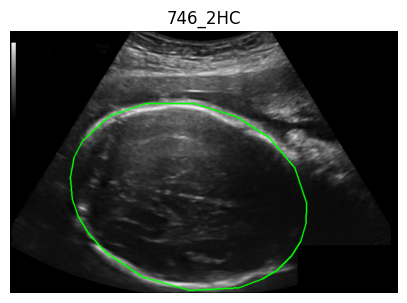

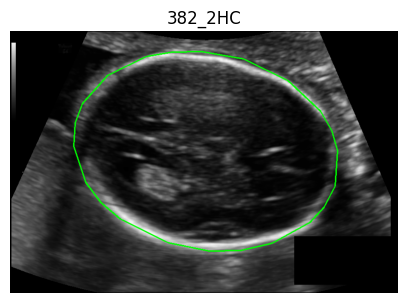

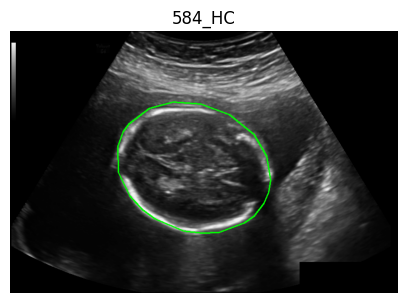

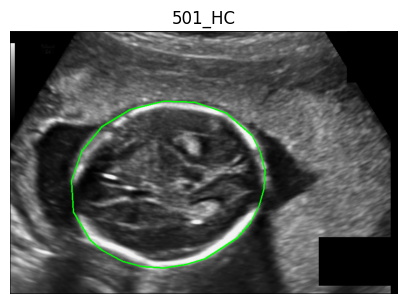

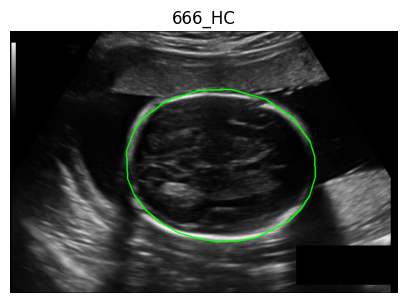

In [ ]:
for img_path in imgs:
    stem = os.path.splitext(os.path.basename(img_path))[0]
    lbl_path = os.path.join(LBL_DIR, f"{stem}.txt")
    if not os.path.exists(lbl_path):
        continue

    img = cv2.imread(img_path)
    if img is None:
        continue

    h, w = img.shape[:2]
    poly = load_yolo_polygon(lbl_path, w, h)
    over = overlay_polygon(img, poly)

    over_rgb = cv2.cvtColor(over, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(5, 5))
    plt.imshow(over_rgb)
    plt.title(stem)
    plt.axis("off")
    plt.show()

    shown += 1
    if shown >= 5:
        break

if shown == 0:
    print("No labeled samples found in images/train. Check that labels/train contains matching .txt files.")

In [ ]:
import yaml


hc_yaml = {
    "path": YOLO_BASE,
    "train": "images/train",
    "val": "images/val",
    "names": {
        0: "fetal_head"
    }
}

yaml_path = os.path.join(YOLO_BASE, "hc.yaml")

with open(yaml_path, "w") as f:
    yaml.dump(hc_yaml, f, sort_keys=False)

print("hc.yaml created at:", yaml_path)

hc.yaml created at: /content/drive/MyDrive/hc_yolo_dataset/hc.yaml


In [ ]:
pip install --upgrade ultralytics

In [ ]:
from ultralytics import YOLO

DATA_YAML = "/content/drive/MyDrive/hc_yolo_dataset/hc.yaml"

model = YOLO("yolo11s-seg.pt")
model.train(
    data=DATA_YAML,
    task="segment",
    epochs=50,
    imgsz=640,
    batch=8,
    device=0,
    workers=2
)

Ultralytics 8.4.7 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/hc_yolo_dataset/hc.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspectiv

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b5a016aa8d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

In [ ]:
#/content/drive/MyDrive/dtset

In [ ]:
import shutil
import os

SRC = "/content/runs"
DST = "/content/drive/MyDrive/dtset/runs"

if os.path.exists(DST):
    shutil.rmtree(DST)

shutil.copytree(SRC, DST)

print("Done:", DST)


In [ ]:
import shutil
import os

SRC = "/content/runs"
DST = "/content/drive/MyDrive/hc_yolo_dataset/runs"

if os.path.exists(DST):
    shutil.rmtree(DST)

shutil.copytree(SRC, DST)

print("Copied 'runs' directory to:", DST)

Copied 'runs' directory to: /content/drive/MyDrive/hc_yolo_dataset/runs



image 1/1 /content/drive/MyDrive/hc_yolo_dataset/images/train/000_HC.png: 448x640 1 fetal_head, 67.0ms
Speed: 2.2ms preprocess, 67.0ms inference, 11.9ms postprocess per image at shape (1, 3, 448, 640)


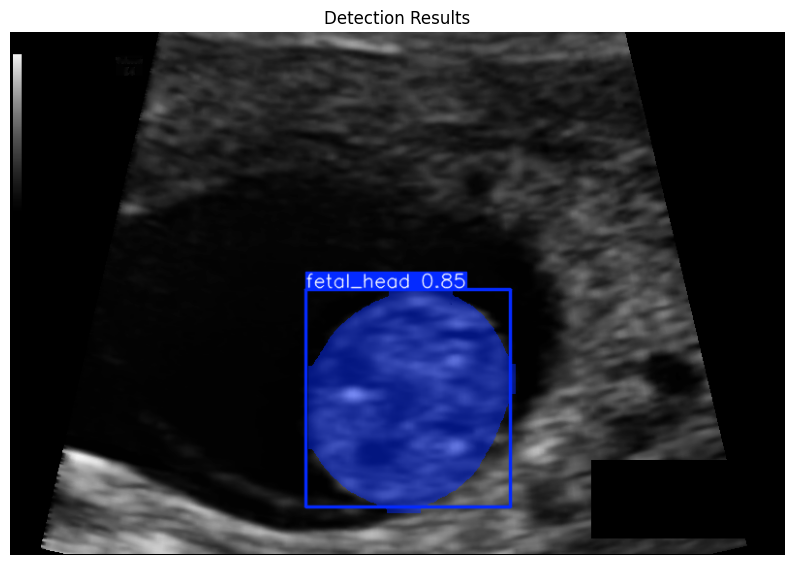

In [ ]:
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/hc_yolo_dataset/images/train/000_HC.png'

results = model.predict(source=image_path, conf=0.5, iou=0.7, show_labels=False, show_conf=False)

for r in results:
    im_array = r.plot()
    im_rgb = im_array[..., ::-1]
    plt.figure(figsize=(10, 10))
    plt.imshow(im_rgb)
    plt.axis('off')
    plt.title('Detection Results')
    plt.show()

In [7]:

from ultralytics import YOLO
MODEL_PATH = "/content/drive/MyDrive/hc_yolo_dataset/runs/segment/train/weights/best.pt"
TEST_DIR = "/content/drive/MyDrive/dtset/test_set/test_set"

model = YOLO(MODEL_PATH)

results = model.predict(
    source=TEST_DIR,
    task="segment",
    conf=0.25,
    save=False
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

image 1/335 /content/drive/MyDrive/dtset/test_set/test_set/000_HC.png: 448x640 1 fetal_head, 63.7ms
image 2/335 /content/drive/MyDrive/dtset/test_set/test_set/001_HC.png: 448x640 1 fetal_head, 15.5ms
image 3/335 /content/drive/MyDrive/dtset/test_set/test_set/002_HC.png: 448x640 1 fetal_head, 15.6ms
image 4/335 /content/drive/MyDrive/dtset/test_set/test_set/003_HC.png: 448x640 1 fetal_head, 15.5ms
image 5/335 /content/drive/MyDrive/dtset/test_set/test_set/004_HC.png: 448x640 1 fetal_head, 15.6ms
image 6/335 /content/drive/MyDrive/dtset/test_set/test_set/005_HC.png: 448x640 1 fetal_head, 15.5ms
image 7/335 /content/drive/MyDrive/dtset/test_set/test_set/006_HC.png: 448x640 1 fetal_h

In [9]:
TEST_CSV = "/content/drive/MyDrive/dtset/test_set_pixel_size.csv"

df = pd.read_csv(TEST_CSV)
df.columns = [c.strip() for c in df.columns]

In [11]:
df.columns

Index(['filename', 'pixel size(mm)'], dtype='object')

In [12]:
FN_COL = "filename"
PX_COL = "pixel size(mm)"

In [13]:
def ramanujan_perimeter(a, b):
    h = ((a - b)**2) / ((a + b)**2 + 1e-12)
    return math.pi * (a + b) * (1 + (3*h)/(10 + math.sqrt(4 - 3*h)))


def polygon_to_mask(poly, h, w):
    mask = np.zeros((h, w), dtype=np.uint8)
    pts = poly.reshape(-1,1,2).astype(np.int32)
    cv2.fillPoly(mask, [pts], 255)
    return mask


def hc_from_polygon(poly, h, w, pixel_size):
    mask = polygon_to_mask(poly, h, w)

    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnt = max(cnts, key=cv2.contourArea)

    ellipse = cv2.fitEllipse(cnt)
    (_, _), (major, minor), _ = ellipse

    a = major / 2
    b = minor / 2

    perim_pixels = ramanujan_perimeter(a, b)

    return perim_pixels * pixel_size

In [14]:
hc_results = []

for r in results:
    img_path = r.path
    fname = os.path.basename(img_path)

    row = df[df[FN_COL] == fname]
    if len(row) == 0:
        print("Pixel size missing for:", fname)
        continue

    pixel_size = float(row[PX_COL].iloc[0])

    if r.masks is None:
        hc_results.append([fname, np.nan])
        continue
    #select the biggest circumference here
    poly = np.array(r.masks.xy[0])

    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    hc_mm = hc_from_polygon(poly, h, w, pixel_size)

    hc_results.append([fname, hc_mm])

In [15]:
for r in results:
    img_path = r.path
    fname = os.path.basename(img_path)

    row = df[df[FN_COL] == fname]
    if len(row) == 0:
        print("Pixel size missing for:", fname)
        continue

    pixel_size = float(row[PX_COL].iloc[0])

    if r.masks is None:
        hc_results.append([fname, np.nan])
        continue

    poly = np.array(r.masks.xy[0])  # biggest object

    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    hc_mm = hc_from_polygon(poly, h, w, pixel_size)

    hc_results.append([fname, hc_mm])


In [16]:

pred_df = pd.DataFrame(hc_results, columns=["filename", "hc_pred_mm"])

out_path = "/content/drive/MyDrive/hc_yolo_dataset/test_hc_predictions.csv"
pred_df.to_csv(out_path, index=False)

print("Done lil bri:", out_path)

Done lil bri: /content/drive/MyDrive/hc_yolo_dataset/test_hc_predictions.csv


In [17]:
train_df = pd.read_csv("/content/drive/MyDrive/dtset/training_set_pixel_size_and_HC.csv")

merged = train_df.merge(pred_df, on="filename", how="inner")

mae = (merged["hc_pred_mm"] - merged["head circumference (mm)"]).abs().mean()
rmse = np.sqrt(((merged["hc_pred_mm"] - merged["head circumference (mm)"])**2).mean())

print("MAE (mm):", mae)
print("RMSE (mm):", rmse)


MAE (mm): 73.82288004050758
RMSE (mm): 95.14696338348999
